In [1]:
# Import libraries 

import pandas as pd 
import ast  # For safely converting string to dictionary
import urllib.request
import fasttext
import pickle
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr  

# Download stopwords and lemmatizer data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Download VADER lexicon
nltk.download('vader_lexicon')



In [2]:
# Load the dataset / Change the paths to match where you store the data 

reviews = pd.read_csv("/Users/lal/Desktop/Github/hotel-recommendation-/data/reviews.csv")
offerings = pd.read_csv("/Users/lal/Desktop/Github/hotel-recommendation-/data/offerings.csv")

#reviews = pd.read_csv("/path/to/data/reviews.csv") 
#offerings = pd.read_csv("/path/to/data/offerings.csv")

# Rename the "id" column in the offerings dataframe to "offering_id" to allow merging
offerings = offerings.rename(columns={"id": "offering_id"})

# Merge the two datasets
df = pd.merge(reviews, offerings, on="offering_id", how="inner")

# Get a subset of the data frame, include the columns that have the ratings (out of 5 for categories), review text, the id, and the name of the hotel.
df_subset = df.loc[:,["ratings","text","offering_id","name"]]

# Check for missing values
print(df_subset.isnull().sum())

# Function to extract all rating categories
def extract_ratings(rating_str):
    try:
        rating_dict = ast.literal_eval(rating_str)  # Convert string to dictionary
        return {
            "overall_rating": rating_dict.get("overall", None),
            "service_rating": rating_dict.get("service", None),
            "cleanliness_rating": rating_dict.get("cleanliness", None),
            "location_rating": rating_dict.get("location", None),
            "value_rating": rating_dict.get("value", None),
            "rooms_rating": rating_dict.get("rooms", None),
        }
    except:
        return {
            "overall_rating": None,
            "service_rating": None,
            "cleanliness_rating": None,
            "location_rating": None,
            "value_rating": None,
            "rooms_rating": None,
        }  # Handle errors safely

# Apply function to extract ratings
rating_columns = df_subset["ratings"].apply(extract_ratings).apply(pd.Series)

# Merge extracted ratings into the main DataFrame
df_subset = pd.concat([df_subset, rating_columns], axis=1)

# Convert all rating columns to numeric
rating_columns_list = ["overall_rating", "service_rating", "cleanliness_rating", 
                       "location_rating", "value_rating", "rooms_rating"]
df_subset[rating_columns_list] = df_subset[rating_columns_list].apply(pd.to_numeric)

# Show column names and data types
print(df_subset.info())

ratings        0
text           0
offering_id    0
name           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878561 entries, 0 to 878560
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ratings             878561 non-null  object 
 1   text                878561 non-null  object 
 2   offering_id         878561 non-null  int64  
 3   name                878561 non-null  object 
 4   overall_rating      878561 non-null  float64
 5   service_rating      760918 non-null  float64
 6   cleanliness_rating  759835 non-null  float64
 7   location_rating     664904 non-null  float64
 8   value_rating        753695 non-null  float64
 9   rooms_rating        705404 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 67.0+ MB
None


In [3]:
# Define model filename
model_filename = "lid.176.bin"

# Check if the model file already exists before downloading
if not os.path.exists(model_filename):
    url = "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin"
    urllib.request.urlretrieve(url, model_filename)
    print("Download complete:", model_filename)
else:
    print("FastText model already exists. Skipping download.")

FastText model already exists. Skipping download.


In [6]:
model = fasttext.load_model("lid.176.bin")

# Function to detect language using FastText
def detect_language_fasttext(text):
    try:
        return model.predict(text)[0][0].replace("__label__", "")  # Extract language code
    except:
        return "unknown"  # Handle errors gracefully

# Apply to dataset
df_subset["language"] = df_subset["text"].apply(detect_language_fasttext)

# Check language distribution
print(df_subset["language"].value_counts())

# Filter only English reviews
df = df_subset[df_subset["language"] == "en"]
df.reset_index(drop=True, inplace=True)  # Reset index after filtering

# Check new dataset size
print("Number of English reviews:", len(df))

language
en         439063
unknown    381012
de          15431
fr          12588
it          11438
es           7894
pt           2927
ja           2019
nl           2003
sv           1746
da            926
no            773
zh            413
ru            172
tr             81
pl             41
el             11
th              9
ko              7
nn              3
id              2
oc              1
fa              1
Name: count, dtype: int64
Number of English reviews: 439063


In [9]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    words = word_tokenize(text)  # Tokenization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization
    return " ".join(words)

# Apply text cleaning to reviews
df["cleaned_text"] = df["text"].apply(clean_text)

# Show cleaned text
print(df[["text", "cleaned_text"]].sample(5))

/var/folders/m1/rvmr_wv50dvb_jqvr2y7l7lh0000gn/T/ipykernel_66021/385188111.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["cleaned_text"] = df["text"].apply(clean_text)


                                                     text  \
216907  rooms and parking area were FILTHY! Staff was ...   
167004  Spent four nights in the Angeleno and throughl...   
188193  The Rittenhouse was new in every way in 1990. ...   
145114  Stayed on business. Was upgraded to a loft sui...   
79297   We travelled with 3 children (age 6,4 and 1). ...   

                                             cleaned_text  
216907  room parking area filthy staff rude bothered h...  
167004  spent four night angeleno throughly enjoyed st...  
188193  rittenhouse new every way 1990 update last 20 ...  
145114  stayed business upgraded loft suite hotel beau...  
79297   travelled 3 child age 6 4 1 booked room two qu...  


In [ ]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply sentiment analysis to each review
df["sentiment_score"] = df["cleaned_text"].apply(get_sentiment)

def categorize_sentiment(score):
    if score > 0.05:
        return "Positive"
    elif score < -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_label"] = df["sentiment_score"].apply(categorize_sentiment)


In [13]:
print(df[["text", "cleaned_text", "sentiment_score","sentiment_label"]].sample(5))

# Display sentiment distribution
print(df["sentiment_label"].value_counts())

                                                     text  \
5073    Motel should be listed 5 Star! We were impress...   
320084  I checked in and found the desk clerk to be so...   
86497   I stayed with my friends. This hotel is locate...   
250852  I used this hotel for guests of my son's weddi...   
335772  There were many things wrong with our stay at ...   

                                             cleaned_text  sentiment_score  \
5073    motel listed 5 star impressed every aspect mot...           0.9726   
320084  checked found desk clerk dirty odor overtook e...          -0.2023   
86497   stayed friend hotel located great area little ...           0.9796   
250852  used hotel guest son wedding adorable hotel re...           0.9489   
335772  many thing wrong stay hotel first quoted one p...          -0.8934   

       sentiment_label  
5073          Positive  
320084        Negative  
86497         Positive  
250852        Positive  
335772        Negative  
sentiment_labe

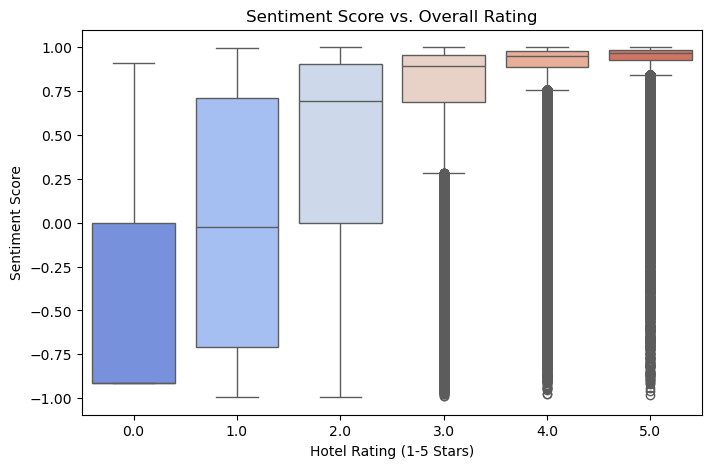

In [15]:
# Plot sentiment score vs. hotel rating
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["overall_rating"], y=df["sentiment_score"], palette="coolwarm")
plt.title("Sentiment Score vs. Overall Rating")
plt.xlabel("Hotel Rating (1-5 Stars)")
plt.ylabel("Sentiment Score")
plt.show()

In [18]:
# Pearson correlation (linear relationship) and p-value (statistical significance)
pearson_corr, pearson_p = pearsonr(df["sentiment_score"], df["overall_rating"])
print(f" Pearson Correlation: {pearson_corr:.4f}, P-value: {pearson_p:.4f}")

 Pearson Correlation: 0.5792, P-value: 0.0000


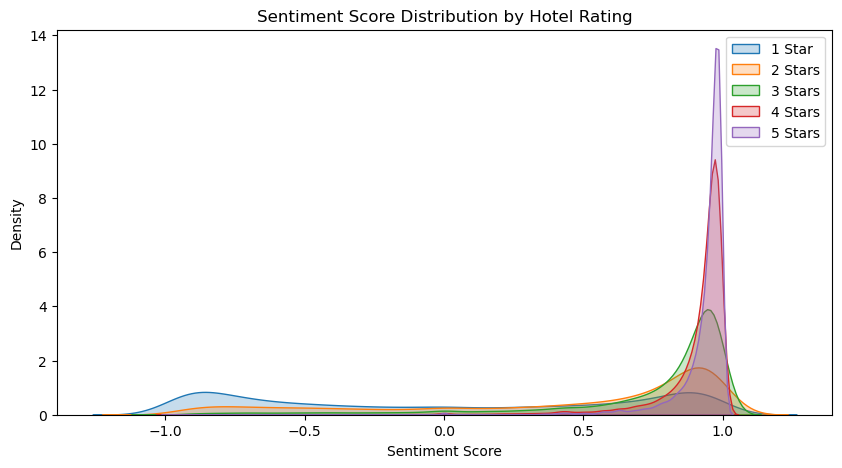

In [20]:
# Create a figure with a defined size
plt.figure(figsize=(10, 5))

# Plot Kernel Density Estimate for sentiment scores of each hotel rating
# This shows the distribution of sentiment scores for different star ratings

sns.kdeplot(df[df["overall_rating"] == 1]["sentiment_score"], label="1 Star", fill=True)  # 1-star hotels
sns.kdeplot(df[df["overall_rating"] == 2]["sentiment_score"], label="2 Stars", fill=True)  # 2-star hotels
sns.kdeplot(df[df["overall_rating"] == 3]["sentiment_score"], label="3 Stars", fill=True)  # 3-star hotels
sns.kdeplot(df[df["overall_rating"] == 4]["sentiment_score"], label="4 Stars", fill=True)  # 4-star hotels
sns.kdeplot(df[df["overall_rating"] == 5]["sentiment_score"], label="5 Stars", fill=True)  # 5-star hotels

# Add a title and axis labels for better readability
plt.title("Sentiment Score Distribution by Hotel Rating")  # Plot title
plt.xlabel("Sentiment Score")  # X-axis label
plt.ylabel("Density")  # Y-axis label

# Display a legend to distinguish the different rating groups
plt.legend()

# Show the plot
plt.show()


In [25]:
# Define thresholds for strongly positive and negative sentiment
positive_threshold = 0.5  # Reviews with sentiment score > 0.5 are considered strongly positive
negative_threshold = -0.5  # Reviews with sentiment score < -0.5 are considered strongly negative

# Filter strongly positive and negative reviews
positive_df = df[df["sentiment_score"] > positive_threshold]  
negative_df = df[df["sentiment_score"] < negative_threshold]  

# Print review counts for each sentiment category
print(f"Positive Reviews: {len(positive_df)} | Negative Reviews: {len(negative_df)}")

Positive Reviews: 391438 | Negative Reviews: 15554


In [24]:
# Initialize TF-IDF Vectorizer (with a limit on the top 5000 words)
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Compute TF-IDF separately for positive and negative reviews
tfidf_pos_matrix = tfidf.fit_transform(positive_df["cleaned_text"])
tfidf_neg_matrix = tfidf.fit_transform(negative_df["cleaned_text"])

# Get the list of words from the TF-IDF model
words = tfidf.get_feature_names_out()

# Compute average TF-IDF score per word for each sentiment category
tfidf_pos_scores = tfidf_pos_matrix.mean(axis=0).tolist()[0]  # Positive words
tfidf_neg_scores = tfidf_neg_matrix.mean(axis=0).tolist()[0]  # Negative words

# Convert results into DataFrames and sort words by importance (TF-IDF score)
tfidf_pos_df = pd.DataFrame({"word": words, "tfidf": tfidf_pos_scores}).sort_values(by="tfidf", ascending=False)
tfidf_neg_df = pd.DataFrame({"word": words, "tfidf": tfidf_neg_scores}).sort_values(by="tfidf", ascending=False)

# Show top 10 words from each sentiment category
print("Top Positive Words:\n", tfidf_pos_df.head())
print("Top Negative Words:\n", tfidf_neg_df.head())


Top Positive Words:
           word     tfidf
2283  includes  0.064741
3801    safety  0.059353
2072   handful  0.043799
4254     stone  0.036318
4222   stating  0.035799
Top Negative Words:
        word     tfidf
3761   room  0.068846
2209  hotel  0.059837
4225   stay  0.032832
2966  night  0.030808
570     bed  0.025417


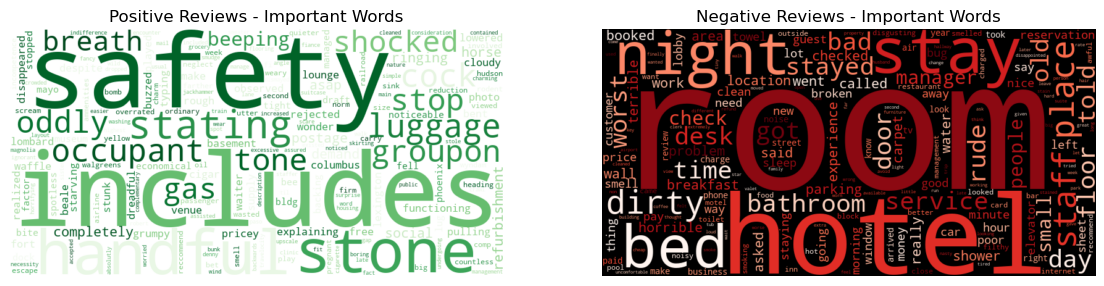

In [28]:
# Extract the top 200 words for each sentiment category
top_pos_words = " ".join(tfidf_pos_df.head(200)["word"])
top_neg_words = " ".join(tfidf_neg_df.head(200)["word"])

# Generate word clouds for positive and negative words
pos_wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(top_pos_words)
neg_wordcloud = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(top_neg_words)

# Plot word clouds side by side for comparison
plt.figure(figsize=(14, 6))

# Left: Positive Reviews Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Reviews - Important Words")

# Right: Negative Reviews Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Reviews - Important Words")

# Show the final visualization
plt.show()

In [34]:
# Initialize TF-IDF Vectorizer (Stopwords already removed during preprocessing)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  

# Convert all hotel reviews into TF-IDF numerical format
tfidf_matrix = tfidf_vectorizer.fit_transform(df["cleaned_text"])  

def get_top_recommendations(user_query, top_n=5):
    """
    Recommend hotels based on TF-IDF similarity and sort them by sentiment score in descending order.
    """
    # Convert the user query into a TF-IDF vector
    query_vector = tfidf_vectorizer.transform([user_query])

    # Compute cosine similarity between query and all reviews
    similarity_scores = cosine_similarity(query_vector, tfidf_matrix)

    # Get indices of the most similar reviews
    top_indices = similarity_scores.argsort()[0][-top_n*3:][::-1]  # Get extra results for better ranking

    # Group by hotel name and compute average sentiment score
    recommended_hotels = df.iloc[top_indices].groupby("name").agg({
        "text": "count",  # Number of reviews per hotel
        "sentiment_score": "mean"  # Average sentiment score
    }).reset_index()

    # Sort hotels by sentiment score in descending order (higher sentiment first)
    recommended_hotels = recommended_hotels.sort_values(by="sentiment_score", ascending=False)

    # Return only the top N hotels
    return recommended_hotels.head(top_n)

# Example: Get recommendations for a "quiet and clean" hotel
user_query = "I am looking for an hotel that is quiet and clean"
print("The user has requested the following attributes in a hotel:", user_query)
recommended_hotels = get_top_recommendations(user_query, top_n=5)

# Display recommendations in Jupyter Notebook
display(recommended_hotels)

The user has requested the following attributes in a hotel: I am looking for an hotel that is quiet and clean


,name,text,sentiment_score
6,Four Points by Sheraton BWI Airport,1,0.9661
9,Homewood Suites Seattle-Downtown,1,0.9595
14,The Westin Indianapolis,1,0.9517
12,The Benjamin,1,0.9349
11,Nob Hill Motor Inn,1,0.9169
